In [1]:
import pandapower as pp
import pandapower.networks as nw

def cigre_grid():
    net = nw.create_cigre_network_mv("pv_wind")
    # set some limits
    min_vm_pu = 0.95
    max_vm_pu = 1.05

    net["bus"].loc[:, "min_vm_pu"] = min_vm_pu
    net["bus"].loc[:, "max_vm_pu"] = max_vm_pu

    net["line"].loc[:, "max_loading_percent"] = 100.

    # close all switches
    net.switch.loc[:, "closed"] = True
    # add storage to bus 10
    pp.create_storage(net, 10, p_mw=0.5, max_e_mwh=.2, soc_percent=0., q_mvar=0., controllable=True)

    return net

In [2]:
import pandas as pd
from pandapower.control import ConstControl
from pandapower.timeseries import DFData

def convert_timeseries_to_controller(net, input_file):
    
    # set the load type in the cigre grid, since it is not specified
    net["load"].loc[:, "type"] = "residential"
    
    # set the sgen type in the cigre grid
    net.sgen.loc[:, "type"] = "pv"
    net.sgen.loc[8, "type"] = "wind"

    # read the example time series
    time_series = pd.read_json(input_file)
    time_series.sort_index(inplace=True)

    # this example time series has a 15min resolution with 96 time steps for one day
    n_timesteps = time_series.shape[0]
    
    # get rated power
    load_p = net["load"].loc[:, "p_mw"].values
    sgen_p = net["sgen"].loc[:7, "p_mw"].values
    wind_p = net["sgen"].loc[8, "p_mw"]

    load_ts = pd.DataFrame(index=time_series.index.tolist(), columns=net.load.index.tolist())
    sgen_ts = pd.DataFrame(index=time_series.index.tolist(), columns=net.sgen.index.tolist())
    for t in range(n_timesteps):
        load_ts.loc[t] = load_p * time_series.at[t, "residential"]
        sgen_ts.loc[t][:8] = sgen_p * time_series.at[t, "pv"]
        sgen_ts.loc[t][8] = wind_p * time_series.at[t, "wind"]

    # create time series controller for load and sgen 
    ConstControl(net, element="load", variable="p_mw",
                 element_index=net.load.index.tolist(), profile_name=net.load.index.tolist(),
                 data_source=DFData(load_ts))
    ConstControl(net, element="sgen", variable="p_mw",
                 element_index=net.sgen.index.tolist(), profile_name=net.sgen.index.tolist(),
                 data_source=DFData(sgen_ts))

In [3]:
# open the cigre mv grid
net = cigre_grid()

# convert the time series to pandapower controller
input_file = "cigre_timeseries_15min.json"
convert_timeseries_to_controller(net, input_file)

In [4]:
# print controller
print("--- time series controller:", net.controller)

# print time series data in controller
print("--- considered element of controller 0:", net.controller.object[0].__dict__["matching_params"]["element"])
print("--- considered element index of controller 0:",net.controller.object[0].__dict__["matching_params"]["element_index"])
print("--- time series data:",net.controller.object[0].data_source.df)

--- time series controller:                      object  in_service  order level  initial_run  \
0  ConstControl [load.p_mw]        True   -1.0    -1        False   
1  ConstControl [sgen.p_mw]        True   -1.0    -1        False   

                                          recycle  
0  {'trafo': False, 'gen': False, 'bus_pq': True}  
1  {'trafo': False, 'gen': False, 'bus_pq': True}  
--- considered element of controller 0: load
--- considered element index of controller 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
--- time series data:            0         1         2         3         4         5         6   \
0    3.838794  0.070777  0.110512  0.186256  0.140313  0.150247  0.121687   
1    3.731032   0.06879   0.10741  0.181027  0.136374  0.146029  0.118271   
2    3.178328    0.0586  0.091498  0.154211  0.116172  0.124397  0.100751   
3    3.026164  0.055795  0.087118  0.146828   0.11061  0.118441  0.095927   
4    3.136205  0.057823  0.090286  0.152167  0.

In [5]:
# run the optimization for the first ten timesteps (the first run can be slow).
try:
    pp.runpm_storage_opf(net, from_time_step=0, to_time_step=10)
except Exception as err:
    print(err)

no costs are given - overall generated power is minimized


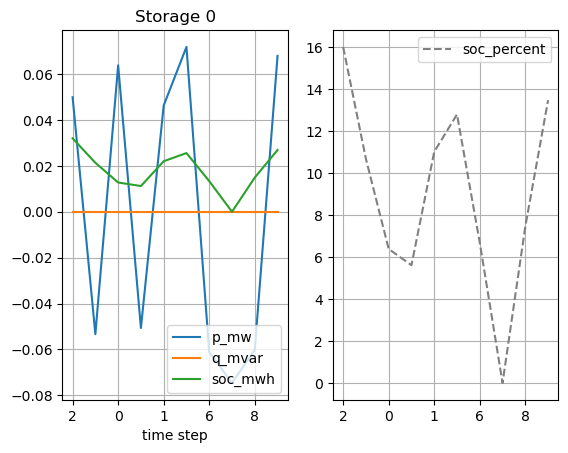

In [9]:
from pandapower.opf.pm_storage import read_pm_storage_results
import matplotlib.pyplot as plt

def plot_storage_results(storage_results):
    n_res = len(storage_results.keys())
    fig, axes = plt.subplots(n_res, 2)
    if n_res == 1:
        axes = [axes]
    for i, (key, val) in enumerate(storage_results.items()):
        res = val
        axes[i][0].set_title("Storage {}".format(key))
        el = res.loc[:, ["p_mw", "q_mvar", "soc_mwh"]]
        el.plot(ax=axes[i][0])
        axes[i][0].set_xlabel("time step")
        axes[i][0].legend(loc=4)
        axes[i][0].grid()
        ax2 = axes[i][1]
        patch = plt.plot([], [], ms=8, ls="--", mec=None, color="grey", label="{:s}".format("soc_percent"))
        ax2.legend(handles=patch)
        ax2.set_label("SOC percent")
        res.loc[:, "soc_percent"].plot(ax=ax2, linestyle="--", color="grey")
        ax2.grid()
    plt.show()

# get the results
storage_results = read_pm_storage_results(net)    
    
# plot the results
plot_storage_results(storage_results)